In [27]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
data_length = 15000
stock = '9064'
gdf_filename_pattern = 'gdf_{}_' + 'len{}'.format(data_length) + '_r{}_s{}_K50'
gdf_parameters = [(1.0, 1.0), (0.1, 0.1), (0.1, 1.0), (1.0, 0.1)]

In [150]:
gdf_dfs = []
for r, s in gdf_parameters:
    gdf_dfs.append(gdf_pca.SvmGdfResults(
        stock,  r=r, s=s, data_length=data_length, 
        gdf_filename_pattern=gdf_filename_pattern))

## Visualization

What do I want to say here?

* that data is quite random
* distribution of queue imbalance
* that there is some correlation between queue imbalance and mid price indicator 
* show some gdf values

In [151]:
df = gdf_dfs[2].df

### Mid Price

Data is quite random, there are outliers

Text(0.5,1,'Mid-Price for 9061 for training dataset')

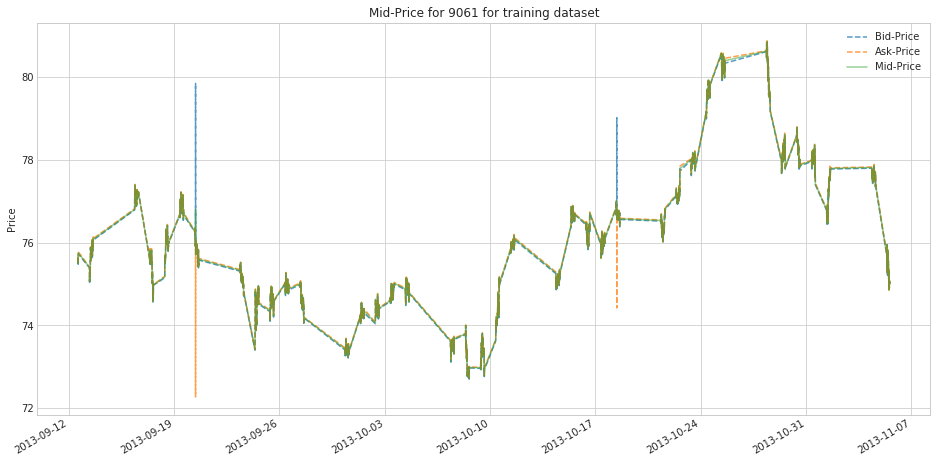

In [152]:
fig, ax = plt.subplots(figsize=(16, 8))

df[['bid_price']].plot(ax=ax, alpha=0.75, linestyle='--')
df[['ask_price']].plot(ax=ax, alpha=0.75, linestyle='--')
df[['mid_price']].plot(ax=ax, alpha=0.5)
plt.legend(['Bid-Price', 'Ask-Price', 'Mid-Price',])
plt.ylabel('Price')
plt.xlabel('')
plt.title('Mid-Price for {} for training dataset'.format(stock))

We can observe outliers, lets look into them - both are around 11 Fridays

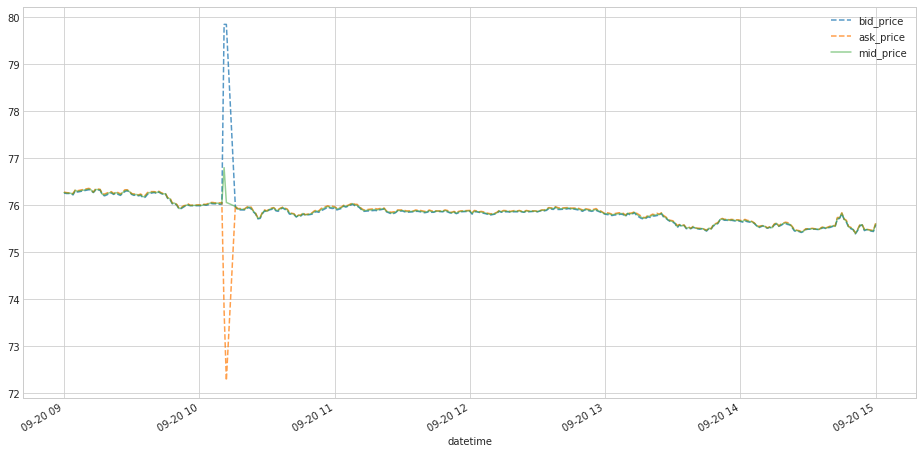

In [153]:
fig, ax = plt.subplots(figsize=(16, 8))
df[['bid_price']].loc['2013-09-20'].plot(ax=ax, alpha=0.75, linestyle='--')
df[['ask_price']].loc['2013-09-20'].plot(ax=ax, alpha=0.75, linestyle='--')
df[['mid_price']].loc['2013-09-20'].plot(ax=ax, alpha=0.5)

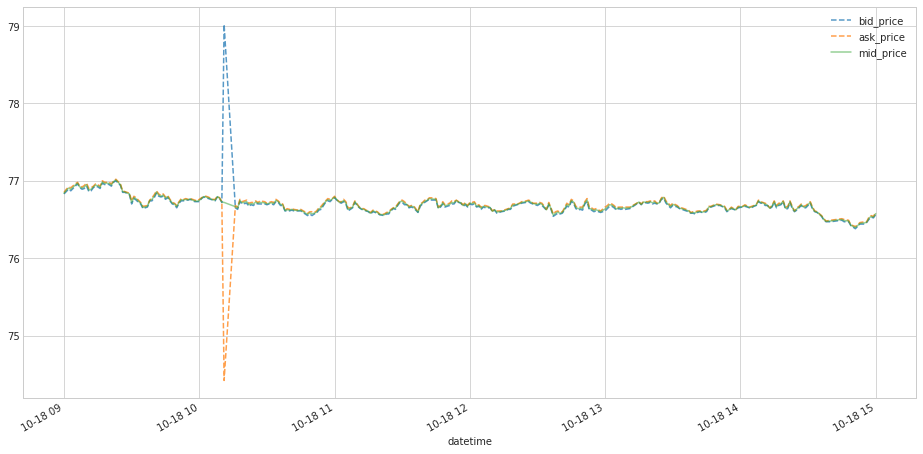

In [154]:
fig, ax = plt.subplots(figsize=(16, 8))
df[['bid_price']].loc['2013-10-18'].plot(ax=ax, alpha=0.75, linestyle='--')
df[['ask_price']].loc['2013-10-18'].plot(ax=ax, alpha=0.75, linestyle='--')
df[['mid_price']].loc['2013-10-18'].plot(ax=ax, alpha=0.5)

### Distributions 

(76.02602175181232, 75.89, 0    74.985
 1    75.990
 dtype: float64)

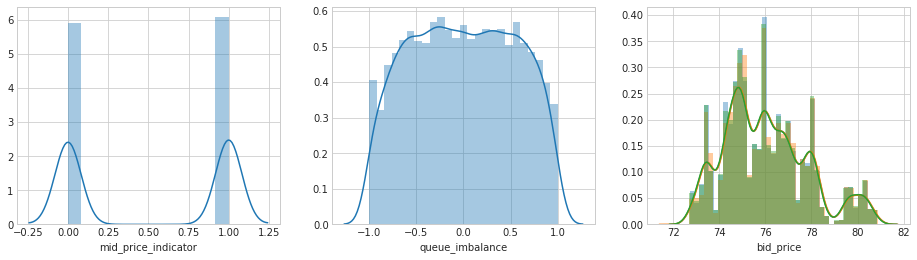

In [155]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.distplot(df['mid_price_indicator'], ax=ax[0])
sns.distplot(df['queue_imbalance'], ax=ax[1])
sns.distplot(df['mid_price'], ax=ax[2])
sns.distplot(df['ask_price'], ax=ax[2])
sns.distplot(df['bid_price'], ax=ax[2])
df['mid_price'].mean(), df['mid_price'].median(), df['mid_price'].mode()

Distribution of Mid-Price Indidcator is balanced (classes are balanced). Mid-Price distribution is slightly Right-Skewed.

(76.02602175181232, 75.89, 0    74.985
 1    75.990
 dtype: float64)

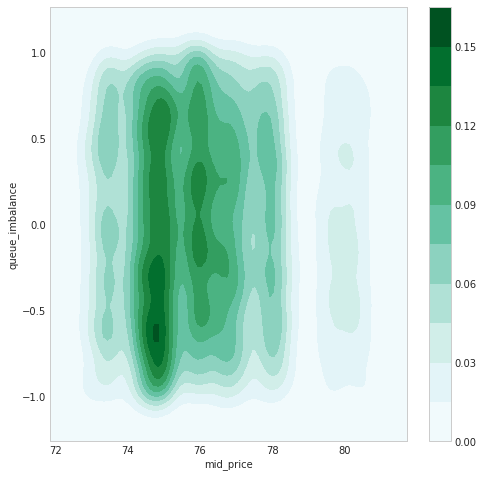

In [156]:
plt.figure(figsize=(8, 8))
sns.kdeplot(df['mid_price'], df['queue_imbalance'], cbar=True, shade=True)
df['mid_price'].mean(), df['mid_price'].median(), df['mid_price'].mode()

We can see that for queue imbalance -1 or 1 the density is the smallest. The highest density for queue imbalance in between -0.5 and 0.5 which happens to be around the mean mid price

### Correlations

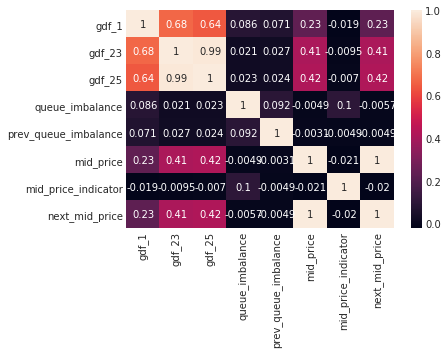

In [158]:
cols = ['gdf_1', 'gdf_23', 'gdf_25', 'queue_imbalance', 'prev_queue_imbalance', 
        'mid_price', 'mid_price_indicator', 'next_mid_price']
sns.heatmap(df[cols].corr(), annot=True)
# TODO: ?

In [104]:
### GDF

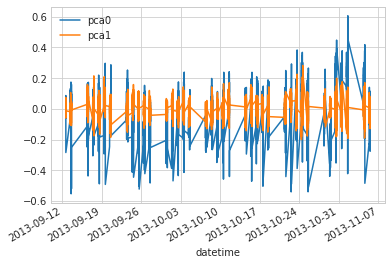

In [159]:
n_components = 2
pca = PCA(n_components=n_components)
gdf_columns = ['gdf_' + str(i) for i in range(0, 50)]
p = pca.fit_transform(df[gdf_columns])

for i in range(n_components):
    df['pca' + str(i)] = p[:, i]
pca_cols = ['pca' + str(i) for i in range(n_components)]

cols = ['gdf_23', 'gdf_25', 'queue_imbalance',
        'mid_price', 'mid_price_indicator']
df[pca_cols].plot()

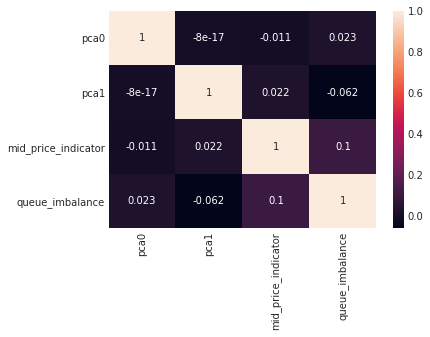

In [160]:

sns.heatmap(df[pca_cols + ['mid_price_indicator', 'queue_imbalance']].corr(), annot=True)

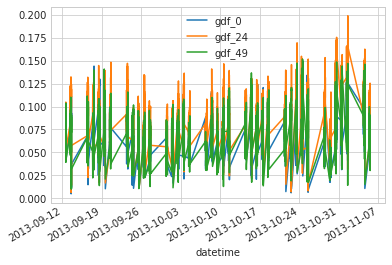

In [161]:
df[['gdf_0', 'gdf_24', 'gdf_49']].plot()

Text(0.5,1,'0.0')

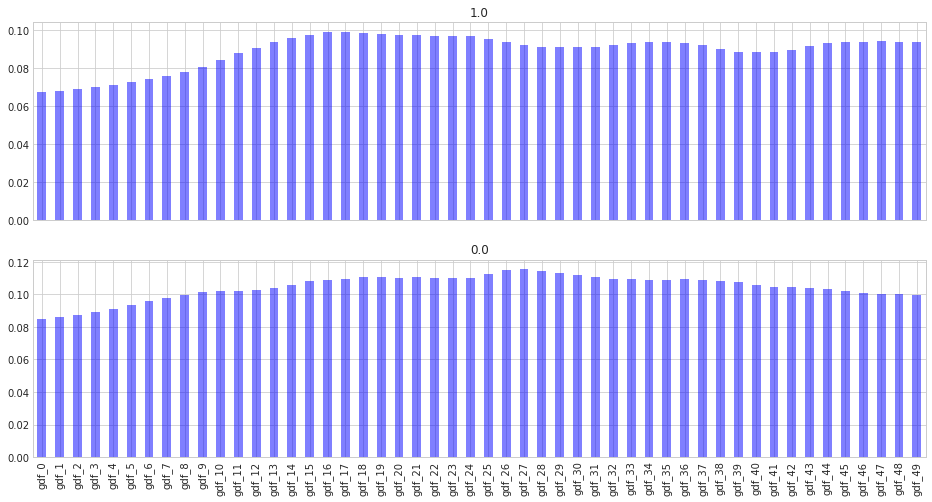

In [162]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
df[gdf_columns].iloc[0].plot('bar', color=['b'], alpha=0.5, ax=ax[0])
df[gdf_columns].iloc[2003].plot('bar', color=['b'], alpha=0.5, ax=ax[1])
ax[0].set_title(df['mid_price_indicator'].iloc[0])
ax[1].set_title(df['mid_price_indicator'].iloc[2003])

Text(0.5,1,'0.0')

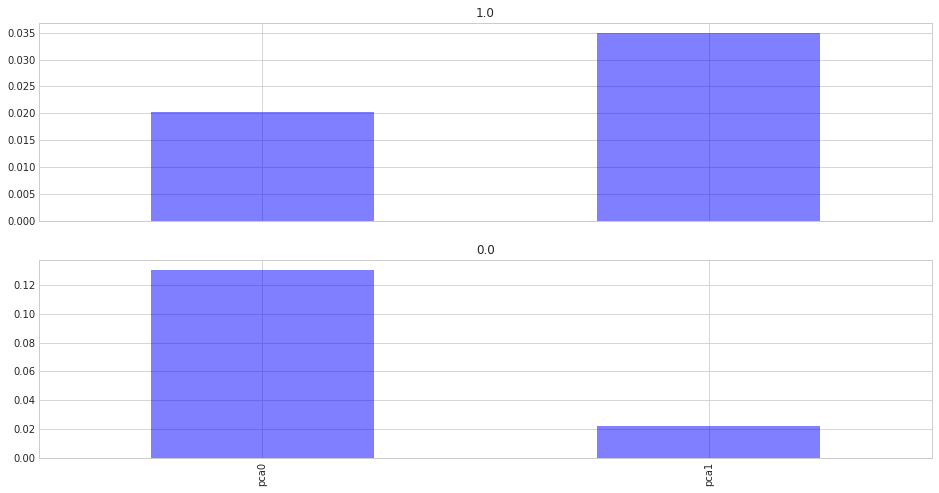

In [163]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
df[pca_cols].iloc[0].plot('bar', color=['b'], alpha=0.5, ax=ax[0])
df[pca_cols].iloc[2003].plot('bar', color=['b'], alpha=0.5, ax=ax[1])
ax[0].set_title(df['mid_price_indicator'].iloc[0])
ax[1].set_title(df['mid_price_indicator'].iloc[2003])

In [164]:
df.head()

,Unnamed: 0,gdf_0,gdf_1,gdf_10,gdf_11,gdf_12,gdf_13,gdf_14,gdf_15,gdf_16,...,mid_price,mid_price_indicator,datetime,bid_price,ask_price,queue_imbalance,prev_queue_imbalance,next_mid_price,pca0,pca1
datetime,,,,,,,,,,,,,,,,,,,,,
2013-09-12 14:43:00,3002,0.067212,0.067827,0.083826,0.087539,0.090337,0.093438,0.095575,0.097320,0.098497,...,75.505,1.0,2013-09-12 14:43:00,75.49,75.52,-0.021731,-0.750835,75.510,0.020215,0.035008
2013-09-12 14:44:00,3003,0.068146,0.071077,0.087577,0.090302,0.093650,0.096161,0.098431,0.100396,0.101838,...,75.510,1.0,2013-09-12 14:44:00,75.49,75.53,0.881878,-0.021731,75.505,0.029924,0.015246
2013-09-12 14:45:00,3004,0.090087,0.091746,0.088914,0.089031,0.088152,0.087411,0.087095,0.086741,0.086606,...,75.615,0.0,2013-09-12 14:45:00,75.60,75.63,-0.484664,0.881878,75.510,0.038071,0.006379
2013-09-12 14:46:00,3005,0.078952,0.079602,0.089263,0.090763,0.091573,0.091193,0.089679,0.088365,0.087200,...,75.570,1.0,2013-09-12 14:46:00,75.55,75.59,0.739090,-0.484664,75.615,0.000567,0.017207
2013-09-12 14:47:00,3006,0.100243,0.099539,0.096626,0.094999,0.092772,0.091110,0.089321,0.087839,0.086697,...,75.630,0.0,2013-09-12 14:47:00,75.62,75.64,0.139432,0.739090,75.570,0.001962,-0.040099


Text(0,0.5,'')

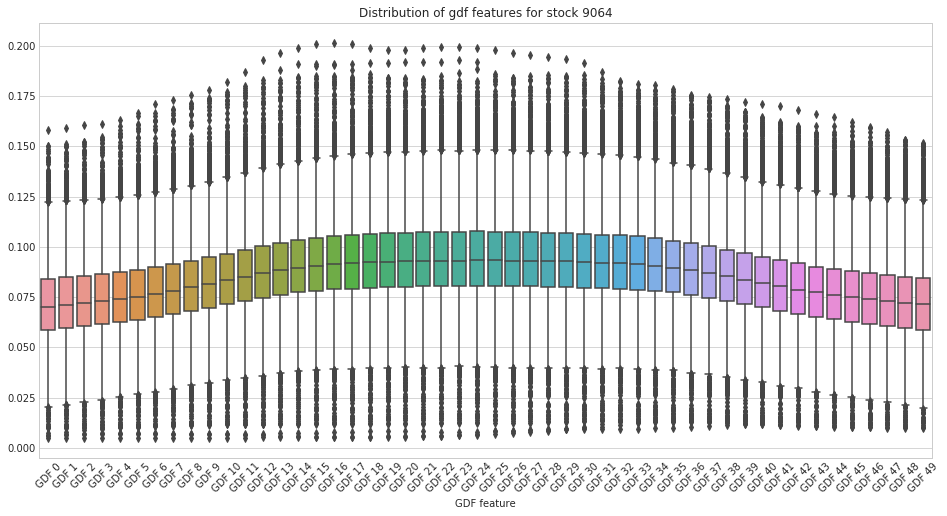

In [165]:
gdf_columns = ['gdf_' + str(i) for i in range(0, 50)]

plt.figure(figsize=(16, 8))
ax = sns.boxplot(data=df[gdf_columns])

_ = ax.set_xticklabels([g.replace('_', ' ').upper() for g in gdf_columns], rotation=45)

plt.title('Distribution of gdf features for stock ' + str(stock))
plt.xlabel('GDF feature')
plt.ylabel('')

Text(0,0.5,'')

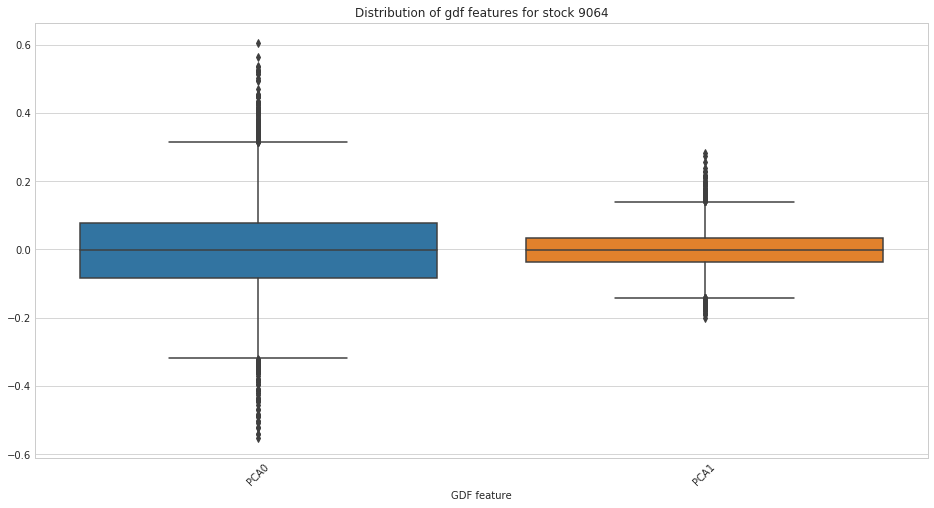

In [166]:
gdf_columns = ['gdf_' + str(i) for i in range(0, 50)]

plt.figure(figsize=(16, 8))
ax = sns.boxplot(data=df[pca_cols])

_ = ax.set_xticklabels([g.replace('_', ' ').upper() for g in pca_cols], rotation=45)

plt.title('Distribution of gdf features for stock ' + str(stock))
plt.xlabel('GDF feature')
plt.ylabel('')

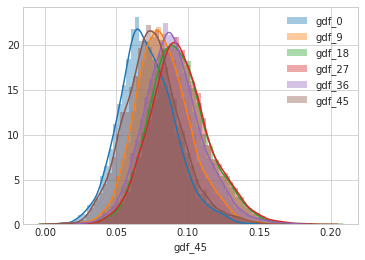

In [167]:
for g in gdf_columns[::9]:
    sns.distplot(df[g], label=g)
plt.legend()

## Predictions

In [180]:
def get_kernel_from_method(method):
    return method.split('_')[1]

class CFR():
    def __init__(self, clf, feature_name, is_svm=True):
        self.clf = clf
        self.feature_name = feature_name
        self.is_svm = is_svm

    def get_result(self, gdf_df, should_validate=False, method=None):
        if self.is_svm:
            return gdf_df.train_svm(C=self.clf.C, gamma=self.clf.gamma, coef0=self.clf.coef0, 
                                    kernel=self.clf.kernel, 
                                    feature_name=self.feature_name, should_validate=should_validate)
        else:
            res = gdf_df.train_log(self.clf, self.feature_name, should_validate=should_validate)
            if method:
                res['kernel'] = method
            return res

### Queue Imbalance - LOGIT, SVM (linear, rbf, sigmoid)

In [169]:
def get_best_svm_results_for_queue_imbalance(s, features):
    df_res = pd.read_csv('res_{}_prev_queue_imbalance.csv'.format(s))
    df_res= df_res[df_res['features'] == features]
    df_res= df_res[df_res['method'] != 'logistic']
    df_res['stock'] = [s for i in range(len(df_res))]
    columns_to_mean = ['f1', 'kappa', 'matthews', 
       'precision', 'recall', 'roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc']
    for c in columns_to_mean:
        cc = []
        for i, row in df_res.iterrows():
            from ast import literal_eval
            cc.append(np.array(literal_eval(row[c])).mean())
        df_res[c] = cc

    return df_res.sort_values(by='matthews', ascending=False).groupby('method').head(1)

In [170]:
df_best_svm_que = get_best_svm_results_for_queue_imbalance(stock, features='queue_imbalance')

In [171]:
log_que_clfs = [
    CFR(clf=LogisticRegression(), feature_name='que', is_svm=False),
]

svm_que_clfs = [
    CFR(
        SVC(kernel=get_kernel_from_method(row['method']), 
            C=row['c'], 
            gamma=row['gamma'], 
            coef0=row['coef0']), feature_name='que') 
                for i, row in df_best_svm_que.iterrows()]


In [172]:
res = []
for clf in log_que_clfs + svm_que_clfs:
    r = clf.get_result(gdf_dfs[0])
    res.append(r)
df_res_que = pd.DataFrame(res)
df_res_que

,C,coef0,features,gamma,kernel,stock,test_f1,test_kappa,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
0,NaN,NaN,que,NaN,logistic,9064,0.579029,0.090139,0.090806,0.548330,0.613368,0.544973,0.561199,0.081829,0.081998,0.544484,0.578973,0.540880
1,1.00,1.0,que,0.1,sigmoid,9064,0.527442,0.088410,0.088884,0.557257,0.500655,0.544286,0.528819,0.089358,0.089734,0.555073,0.504936,0.544733
2,0.01,NaN,que,1000.0,rbf,9064,0.674475,0.000000,0.000000,0.508836,1.000000,0.500000,0.672457,0.000000,0.000000,0.506542,1.000000,0.500000
3,0.10,NaN,que,NaN,linear,9064,0.566794,0.090427,0.090598,0.550680,0.583879,0.545164,0.550061,0.079027,0.079042,0.544780,0.555446,0.539503


### Queue Imbalance and Prev Queue Imbalance

In [176]:
df_best_svm_prev_que = get_best_svm_results_for_queue_imbalance(
    stock, features='queue_imbalance, prev_queue_imbalance')

In [177]:
prev_que_log_clfs = [
    CFR(clf=LogisticRegression(), feature_name='que_prev', is_svm=False),
]

svm_prev_que_clfs = [
    CFR(
        SVC(kernel=get_kernel_from_method(row['method']), 
            C=row['c'], 
            gamma=row['gamma'], 
            coef0=row['coef0']), feature_name='que_prev') 
                for i, row in df_best_svm_prev_que.iterrows()]

In [178]:
res = []
for clf in prev_que_log_clfs + svm_prev_que_clfs:
    r = clf.get_result(gdf_dfs[0])
    res.append(r)
df_res_que_prev = pd.DataFrame(res)
df_res_que_prev

,C,coef0,features,gamma,kernel,stock,test_f1,test_kappa,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
0,NaN,NaN,que_prev,NaN,logistic,9064,0.574741,0.093263,0.093668,0.550751,0.600917,0.546555,0.561303,0.083023,0.083183,0.545116,0.578480,0.541478
1,10.0,NaN,que_prev,0.10,rbf,9064,0.564593,0.088520,0.088657,0.550031,0.579948,0.544217,0.554779,0.086473,0.086499,0.548185,0.561533,0.543222
2,100.0,0.1,que_prev,0.01,sigmoid,9064,0.589474,0.086472,0.087952,0.544747,0.642202,0.543097,0.580360,0.080508,0.081563,0.540779,0.626193,0.540170
3,100.0,NaN,que_prev,NaN,linear,9064,0.565231,0.089856,0.089994,0.550653,0.580603,0.544884,0.552280,0.083185,0.083203,0.546759,0.557914,0.541581


### GDF Plain

In [66]:
df_gdf_plain_res = pd.DataFrame()
gdf_results_dir = '../gaussian_filter/data_res_9061_len15000'
results_files = os.listdir(gdf_results_dir)
results_files = [f for f in results_files if stock in f and 'partial' not in f]
for f in results_files:
    temp_df = pd.read_csv(os.path.join(gdf_results_dir, f))
    df_gdf_plain_res = df_gdf_plain_res.append(temp_df)
print(df_gdf_plain_res.columns)
df_gdf_plain_res.sort_values(by='matthews', ascending=False).groupby('kernel').head(1)

Index(['Unnamed: 0', 'C', 'coef0', 'f1', 'features', 'gamma', 'kappa',
       'kernel', 'matthews', 'precision', 'recall', 'roc_auc', 'stock',
       'test_f1', 'test_kappa', 'test_matthews', 'test_precision',
       'test_recall', 'test_roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc'],
      dtype='object')


,Unnamed: 0,C,coef0,f1,features,gamma,kappa,kernel,matthews,precision,...,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
32,32,10.000,NaN,0.322123,gdf_23-27,10.0,0.031676,rbf,0.041847,0.441331,...,0.05433,0.539181,0.309812,0.524529,0.313378,0.034542,0.039485,0.414109,0.294915,0.517164
0,0,0.001,NaN,0.068039,gdf_23-27,NaN,0.000000,linear,0.000000,0.049032,...,0.00000,0.000000,0.000000,0.500000,0.074795,0.000000,0.000000,0.056371,0.111111,0.500000


In [ ]:
r = 1.0
s = 0.1
C = 1.0 
gamma = 10000.0
filename = 'data_gdf/gdf_{}_len{}_r{}_s{}_K{}.csv'.format(stock, length, r, s, K)

### GDF with PCA

In [179]:
df_gdf_res = pd.DataFrame()
gdf_results_dir = '../gdf_pca/res_pca_gdf3_15000'
results_files = os.listdir(gdf_results_dir)
results_files = [f for f in results_files if stock in f and 'partial' not in f]
for f in results_files:
    temp_df = pd.read_csv(os.path.join(gdf_results_dir, f))
    df_gdf_res = df_gdf_res.append(temp_df)

df_gdf_res.sort_values(by='matthews', ascending=False).groupby('kernel').head(2)

,Unnamed: 0,C,coef0,f1,features,gamma,kappa,kernel,matthews,precision,...,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
19,19,100.0,1.0,0.523379,pca_gdf_que3,0.01,0.088409,sigmoid,0.089446,0.557420,...,0.090150,0.563636,0.446920,0.544234,0.540548,0.082789,0.083271,0.553571,0.530595,0.541437
19,19,100.0,1.0,0.522823,pca_gdf_que3,0.01,0.086601,sigmoid,0.087608,0.556519,...,0.092460,0.565471,0.444299,0.545299,0.540720,0.083171,0.083631,0.553788,0.530637,0.541630
4,4,10.0,NaN,0.551001,pca_gdf_que3,NaN,0.086377,linear,0.086634,0.550605,...,0.091219,0.550769,0.586501,0.545457,0.563532,0.076295,0.076560,0.545617,0.583202,0.538087
3,3,1.0,NaN,0.550228,pca_gdf_que3,NaN,0.086341,linear,0.086564,0.550713,...,0.089204,0.549815,0.585845,0.544450,0.563029,0.076850,0.077085,0.545946,0.581626,0.538366
30,30,10.0,NaN,0.570978,pca_gdf_que3,0.10,0.085041,rbf,0.086370,0.546479,...,0.090129,0.548009,0.613368,0.544634,0.578721,0.069239,0.070312,0.540489,0.625412,0.534523
17,17,0.1,NaN,0.557671,pca_gdf_que3,1.00,0.085519,rbf,0.085808,0.548548,...,0.087274,0.544248,0.644823,0.542710,0.569393,0.075496,0.075915,0.544304,0.597276,0.537675


In [67]:
df_gdf_res = pd.DataFrame()
gdf_results_dir = '../gdf_pca/res_pca1_gdf_que_15000'
results_files = os.listdir(gdf_results_dir)
results_files = [f for f in results_files if stock in f and 'partial' not in f]
for f in results_files:
    temp_df = pd.read_csv(os.path.join(gdf_results_dir, f))
    df_gdf_res = df_gdf_res.append(temp_df)

df_gdf_res.sort_values(by='matthews', ascending=False).groupby('kernel').head(2)

,Unnamed: 0,C,coef0,f1,features,gamma,kappa,kernel,matthews,precision,...,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
44,44,1000.0,NaN,0.477132,pca_gdf_que_pca1,0.10,0.099900,rbf,0.106379,0.567579,...,0.055509,0.531858,0.403898,0.526899,0.473722,0.088808,0.091659,0.547815,0.421721,0.544120
23,23,1.0,NaN,0.456378,pca_gdf_que_pca1,0.10,0.097769,rbf,0.105979,0.571852,...,0.058322,0.536873,0.366935,0.527611,0.451024,0.085731,0.090436,0.551350,0.387453,0.542527
4,4,10.0,NaN,0.537194,pca_gdf_que_pca1,NaN,0.099814,linear,0.101237,0.548870,...,0.065428,0.530271,0.512097,0.532686,0.534314,0.090968,0.091016,0.535531,0.533336,0.545457
6,6,1000.0,NaN,0.538406,pca_gdf_que_pca1,NaN,0.099086,linear,0.100447,0.548253,...,0.066776,0.530881,0.514113,0.533364,0.534781,0.092373,0.092419,0.536363,0.533436,0.546156
18,18,100.0,0.01,0.539035,pca_gdf_que_pca1,0.01,0.098381,sigmoid,0.099658,0.547613,...,0.069466,0.532135,0.517473,0.534713,0.535243,0.091331,0.091375,0.535639,0.535066,0.545641
18,18,100.0,0.01,0.538178,pca_gdf_que_pca1,0.01,0.096593,sigmoid,0.097936,0.546691,...,0.070137,0.532459,0.518145,0.535049,0.535690,0.091774,0.091821,0.535831,0.535788,0.545863


In [72]:
df_gdf_res = pd.DataFrame()
gdf_results_dir = '../gdf_pca/res_pca2_gdf_que_15000'
results_files = os.listdir(gdf_results_dir)
results_files = [f for f in results_files if stock in f and 'partial' not in f]
for f in results_files:
    temp_df = pd.read_csv(os.path.join(gdf_results_dir, f))
    df_gdf_res = df_gdf_res.append(temp_df)

df_gdf_res.sort_values(by='matthews', ascending=False).groupby('kernel').head(2)

,Unnamed: 0,C,coef0,f1,features,gamma,kappa,kernel,matthews,precision,...,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
44,44,1000.0,NaN,0.475799,pca_gdf_que_pca2,0.10,0.099562,rbf,0.106222,0.567937,...,0.053448,0.530558,0.402554,0.525896,0.472714,0.088908,0.091790,0.548021,0.419973,0.544171
43,43,1000.0,NaN,0.434382,pca_gdf_que_pca2,0.01,0.095329,rbf,0.105561,0.576707,...,0.043403,0.528711,0.327957,0.520034,0.430563,0.083669,0.090262,0.556109,0.357344,0.541448
4,4,10.0,NaN,0.536402,pca_gdf_que_pca2,NaN,0.099035,linear,0.100538,0.548718,...,0.065428,0.530271,0.512097,0.532686,0.533900,0.091330,0.091371,0.535897,0.532122,0.545637
4,4,10.0,NaN,0.536112,pca_gdf_que_pca2,NaN,0.098660,linear,0.100074,0.548525,...,0.066756,0.531010,0.512097,0.533348,0.534078,0.091387,0.091426,0.535898,0.532470,0.545666
18,18,100.0,0.01,0.538007,pca_gdf_que_pca2,0.01,0.096916,sigmoid,0.098218,0.546866,...,0.069459,0.532180,0.516801,0.534708,0.534599,0.090397,0.090441,0.535131,0.534288,0.545174
18,18,100.0,0.01,0.537919,pca_gdf_que_pca2,0.01,0.096853,sigmoid,0.098162,0.546872,...,0.067440,0.531250,0.514113,0.533694,0.534586,0.090436,0.090473,0.535199,0.534168,0.545195


In [183]:
from sklearn.neural_network import MLPClassifier
alphas = [0.01, 0.1, 1.0]
activations = ['tanh']
solvers = ['adam']
hidden_layer_sizes = [(3, 3), (10, 3), (3, 10), (10, 10)]
features = ['pca_gdf_que_prev3', 'pca_gdf_que_prev5']
res1 = []

for feature in features:
    for hidden_layer_size in hidden_layer_sizes:
        for solver in solvers:
            for activation in activations:
                for alpha in alphas:
                    clf = MLPClassifier(solver=solver, alpha=alpha, activation=activation,
                                              hidden_layer_sizes=hidden_layer_size, random_state=1)

                    c = CFR(clf=clf, feature_name=feature, is_svm=False)
                    r = c.get_result(gdf_dfs[0], should_validate=True, method='mlp')
                    res1.append({**r, 'hidden_layer_size': hidden_layer_size, 
                                'alpha': alpha, 'activation': activation, 'solver': solver})
pd.DataFrame(res1)

,activation,alpha,f1,features,hidden_layer_size,kappa,kernel,matthews,precision,recall,...,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
0,tanh,0.01,0.570339,pca_gdf_que_prev3,"(3, 3)",0.078279,mlp,0.079490,0.543287,0.604618,...,0.099331,0.546359,0.683486,0.547785,0.579971,0.072443,0.073449,0.541315,0.625270,0.536092
1,tanh,0.10,0.569991,pca_gdf_que_prev3,"(3, 3)",0.079334,mlp,0.080537,0.543883,0.603212,...,0.098342,0.547363,0.666448,0.547752,0.579135,0.073671,0.074616,0.541989,0.622444,0.536708
2,tanh,1.00,0.577422,pca_gdf_que_prev3,"(3, 3)",0.091329,mlp,0.092316,0.548571,0.611506,...,0.094537,0.542313,0.709699,0.544598,0.580013,0.073141,0.074116,0.541740,0.624839,0.536446
3,tanh,0.01,0.558315,pca_gdf_que_prev3,"(10, 3)",0.080048,mlp,0.081259,0.546466,0.576556,...,0.093320,0.554397,0.557667,0.546654,0.560749,0.074851,0.075201,0.546231,0.579462,0.537393
4,tanh,0.10,0.560690,pca_gdf_que_prev3,"(10, 3)",0.080137,mlp,0.081317,0.546109,0.581762,...,0.097090,0.555484,0.567497,0.548514,0.565370,0.075026,0.075469,0.545577,0.589992,0.537463
5,tanh,1.00,0.576409,pca_gdf_que_prev3,"(10, 3)",0.084797,mlp,0.086290,0.545379,0.615323,...,0.106088,0.549550,0.679554,0.551250,0.584118,0.072844,0.074108,0.541242,0.635775,0.536284
6,tanh,0.01,0.561753,pca_gdf_que_prev3,"(3, 10)",0.074214,mlp,0.076105,0.542021,0.593032,...,0.099498,0.550056,0.640891,0.548891,0.572874,0.061904,0.063047,0.537660,0.617735,0.530853
7,tanh,0.10,0.561949,pca_gdf_que_prev3,"(3, 10)",0.072374,mlp,0.074206,0.540977,0.594420,...,0.096783,0.548931,0.639581,0.547557,0.574097,0.061278,0.062092,0.537494,0.620837,0.530553
8,tanh,1.00,0.576540,pca_gdf_que_prev3,"(3, 10)",0.080281,mlp,0.082275,0.542935,0.620249,...,0.098767,0.545691,0.688729,0.547351,0.588285,0.070968,0.072841,0.539809,0.648629,0.535322
9,tanh,0.01,0.565321,pca_gdf_que_prev3,"(10, 10)",0.078243,mlp,0.079232,0.544113,0.593434,...,0.100846,0.551136,0.635649,0.549664,0.576157,0.076462,0.077473,0.544051,0.614569,0.538113


In [185]:
df_res1 = pd.DataFrame(res1)
df_res1.sort_values(by='test_matthews', ascending=False).head()

,activation,alpha,f1,features,hidden_layer_size,kappa,kernel,matthews,precision,recall,...,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
5,tanh,1.00,0.576409,pca_gdf_que_prev3,"(10, 3)",0.084797,mlp,0.086290,0.545379,0.615323,...,0.106088,0.549550,0.679554,0.551250,0.584118,0.072844,0.074108,0.541242,0.635775,0.536284
15,tanh,0.01,0.554063,pca_gdf_que_prev5,"(10, 3)",0.087569,mlp,0.088055,0.550621,0.560102,...,0.101753,0.557692,0.570118,0.550843,0.557282,0.075634,0.075843,0.546669,0.570139,0.537783
9,tanh,0.01,0.565321,pca_gdf_que_prev3,"(10, 10)",0.078243,mlp,0.079232,0.544113,0.593434,...,0.100846,0.551136,0.635649,0.549664,0.576157,0.076462,0.077473,0.544051,0.614569,0.538113
14,tanh,1.00,0.576149,pca_gdf_que_prev5,"(3, 3)",0.087136,mlp,0.088193,0.546678,0.611507,...,0.100319,0.545782,0.695282,0.547912,0.582174,0.076772,0.077787,0.543210,0.627620,0.538254
6,tanh,0.01,0.561753,pca_gdf_que_prev3,"(3, 10)",0.074214,mlp,0.076105,0.542021,0.593032,...,0.099498,0.550056,0.640891,0.548891,0.572874,0.061904,0.063047,0.537660,0.617735,0.530853


In [181]:
from sklearn.neural_network import MLPClassifier
alphas = [0.0001, 0.001, 0.1, 1.0] # sgd with alpha = 1
activations = ['identity', 'logistic', 'tanh', 'relu']
solvers = ['adam', 'sgd']
hidden_layer_sizes = [(3, 3), (10, 3), (3, 10), (10, 10)]

res = []

for hidden_layer_size in hidden_layer_sizes:
    for solver in solvers:
        for activation in activations:
            for alpha in alphas:
                clf = MLPClassifier(solver=solver, alpha=alpha, activation=activation,
                                          hidden_layer_sizes=hidden_layer_size, random_state=1)

                c = CFR(clf=clf, feature_name='pca_gdf_que_prev10', is_svm=False)
                r = c.get_result(gdf_dfs[0], should_validate=True, method='mlp')
                res.append({**r, 'hidden_layer_size': hidden_layer_size, 
                            'alpha': alpha, 'activation': activation, 'solver': solver})
pd.DataFrame(res)

,activation,alpha,f1,features,hidden_layer_size,kappa,kernel,matthews,precision,recall,...,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
0,identity,0.0001,0.573677,pca_gdf_que_prev10,"(3, 3)",0.068123,mlp,0.069010,0.538291,0.618373,...,0.087307,0.545558,0.627785,0.543017,0.581980,0.070416,0.071519,0.540432,0.631934,0.535086
1,identity,0.0010,0.573755,pca_gdf_que_prev10,"(3, 3)",0.068110,mlp,0.069002,0.538264,0.618572,...,0.087982,0.545817,0.628440,0.543344,0.581937,0.070220,0.071322,0.540342,0.631951,0.534989
2,identity,0.1000,0.573102,pca_gdf_que_prev10,"(3, 3)",0.065462,mlp,0.066223,0.537044,0.618351,...,0.098168,0.548835,0.648100,0.548082,0.582399,0.068927,0.070144,0.539557,0.634130,0.534337
3,identity,1.0000,0.566741,pca_gdf_que_prev10,"(3, 3)",0.067877,mlp,0.068548,0.538824,0.601387,...,0.095133,0.544929,0.679554,0.545819,0.580058,0.062399,0.063603,0.536588,0.632541,0.531080
4,logistic,0.0001,0.668854,pca_gdf_que_prev10,"(3, 3)",0.005006,mlp,0.005860,0.509816,0.977739,...,0.000000,0.508836,1.000000,0.500000,0.669133,-0.001516,-0.001834,0.510126,0.975140,0.499244
5,logistic,0.0010,0.668854,pca_gdf_que_prev10,"(3, 3)",0.005006,mlp,0.005860,0.509816,0.977739,...,0.000000,0.508836,1.000000,0.500000,0.669078,-0.001617,-0.001955,0.510094,0.975038,0.499193
6,logistic,0.1000,0.667034,pca_gdf_que_prev10,"(3, 3)",0.004722,mlp,0.005202,0.509832,0.972319,...,0.000000,0.508836,1.000000,0.500000,0.667286,-0.003735,-0.004335,0.509376,0.970979,0.498137
7,logistic,1.0000,0.673830,pca_gdf_que_prev10,"(3, 3)",0.000000,mlp,0.000000,0.508257,1.000000,...,0.000000,0.508836,1.000000,0.500000,0.676021,0.000000,0.000000,0.510609,1.000000,0.500000
8,tanh,0.0001,0.584304,pca_gdf_que_prev10,"(3, 3)",0.062278,mlp,0.064358,0.535298,0.655525,...,0.092749,0.548331,0.624509,0.545791,0.592944,0.065117,0.067003,0.538112,0.668618,0.532439
9,tanh,0.0010,0.584204,pca_gdf_que_prev10,"(3, 3)",0.062070,mlp,0.064111,0.535242,0.655317,...,0.092745,0.548276,0.625164,0.545779,0.593007,0.065147,0.067051,0.538108,0.668794,0.532454


In [182]:
df_res = pd.DataFrame(res)
df_res.sort_values(by='matthews', ascending=False).groupby('solver').head(2)

,activation,alpha,f1,features,hidden_layer_size,kappa,kernel,matthews,precision,recall,...,test_matthews,test_precision,test_recall,test_roc_auc,train_f1,train_kappa,train_matthews,train_precision,train_recall,train_roc_auc
74,tanh,0.1,0.569715,pca_gdf_que_prev10,"(3, 10)",0.088760,mlp,0.089655,0.548906,0.596496,...,0.087435,0.546838,0.612058,0.543300,0.578782,0.082120,0.083204,0.546455,0.617093,0.540931
43,tanh,1.0,0.575302,pca_gdf_que_prev10,"(10, 3)",0.088112,mlp,0.089363,0.547153,0.610423,...,0.100989,0.546110,0.694626,0.548264,0.582626,0.076472,0.077675,0.543057,0.629624,0.538093
59,tanh,1.0,0.556571,pca_gdf_que_prev10,"(10, 3)",0.082120,mlp,0.083136,0.546447,0.573520,...,0.103215,0.546571,0.699869,0.549188,0.575981,0.063563,0.064365,0.537683,0.620680,0.531677
51,identity,1.0,0.555261,pca_gdf_que_prev10,"(10, 3)",0.080932,mlp,0.081881,0.546400,0.570518,...,0.105669,0.548438,0.690039,0.550722,0.576144,0.071044,0.071833,0.541239,0.616558,0.535410
